In [1]:
import json
import torch
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as tfidf_cosine_similarity
from torch.nn.functional import cosine_similarity as torch_cosine_similarity

import RAG_LLM
import matplotlib.pyplot as plt
import numpy as np

c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Charge les annotations, les documents et les équipes
def chargement_donnees(fichier_annotations, fichier_documents, fichier_equipes):
    with open(fichier_annotations, "r", encoding="utf-8") as f:
        annotations = json.load(f)
    with open(fichier_documents, "r", encoding="utf-8") as f:
        documents = json.load(f)
    with open(fichier_equipes, "r", encoding="utf-8") as f:
        equipes = json.load(f)
    return annotations, documents, equipes

In [3]:
# Fonction pour trouver les embeddings les plus similaires
def trouve_similaire(query, query_embeddings, embeddings, informations):
    # On met les embeddings et le prompt sur le même device
    embeddings = embeddings.to(query_embeddings.device)
    query_embeddings = query_embeddings.unsqueeze(0)

    # Recherche sémantique
    score_similarite = torch_cosine_similarity(query_embeddings, embeddings, dim=1)

    # Recherche TF-IDF
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(informations)
    tfidf_query = tfidf_vectorizer.transform([query])
    score_tfidf = torch.tensor(
        tfidf_cosine_similarity(tfidf_query, tfidf_matrix).flatten(),
        device=query_embeddings.device,
        dtype=torch.float32
    )

    # Combinaison des scores
    score_combinaison = 0.3 * score_similarite + 0.7 * score_tfidf

    # Récupération des indices triés
    indices = score_combinaison.argsort(descending=True).tolist()
    return [(score_combinaison[i].item(), i) for i in indices]


In [4]:
# Évalue les performances du système pour une requête donnée
def evaluation_requete(query, resultats_rag, resultats_attendus, informations_documents, informations_equipes):
    # Créer les ensembles de documents et d'équipes attendus
    documents = [informations_documents[i] for _, i in resultats_rag[:6]]
    equipes = [informations_equipes[i] for _, i in resultats_rag[6:]]
    set_systeme = set(documents + equipes)
    set_attendus = set(resultats_attendus)

    reponses_presentes = 0
    max_reponses_possible = min(len(set_systeme)-1, len(set_attendus)) # On a au maximum 6 éléments trouvables

    # On regarde si les élements attendus sont dans les résultats du système
    for texte in set_attendus:
        if reponses_presentes == max_reponses_possible:
            break
        for reponse in set_systeme:
            if texte in reponse:
                reponses_presentes += 1
                break

    # Calcul de l'efficacité
    efficacite = reponses_presentes / max_reponses_possible

    return efficacite

In [5]:
# Fonction qui évalue les requêtes pour une catégorie donnée
def evaluation_categorie(requetes_categorie, informations_documents, informations_equipes, embeddings, modele):
    resultats = []
    efficacite_totale = 0

    # On évalue le RAG pour chaque annotation
    for requete in requetes_categorie:
        # Récupération de la requête et des résultats attendus
        query = requete["query"]
        resultats_attendus = requete["expected_results"]

        # Répétition de l'évaluation 10 fois
        efficacites = []
        for _ in range(10):
            # Récupération des embeddings de la requête
            query_mots_cles = RAG_LLM.get_mots_cles_query(query)
            query_embedding = modele.encode(query_mots_cles, convert_to_tensor=True)

            # Trouve les embeddings les plus similaires
            doc_similaires = trouve_similaire(query, query_embedding, embeddings[0], informations_documents)[:6]
            equipes_similaires = trouve_similaire(query, query_embedding, embeddings[1], informations_equipes)[:1]
            resultats_rag = doc_similaires + equipes_similaires

            # Évaluation
            efficacites.append(evaluation_requete(query, resultats_rag, resultats_attendus, informations_documents, informations_equipes))
        
        # Moyenne des efficacités
        efficacite_moyenne_requete = sum(efficacites) / len(efficacites)
        efficacite_totale += efficacite_moyenne_requete

        resultats.append({
            "query": query,
            "efficacite": f"{round(efficacite_moyenne_requete * 100, 2)}%",  # En pourcentage
        })

    # Calcul de l'efficacité moyenne pour la catégorie
    efficacite_moyenne_categorie = efficacite_totale / len(requetes_categorie)

    return {
        "Nombre_requetes": len(requetes_categorie),
        "Efficacite_moyenne": f"{round(efficacite_moyenne_categorie * 100, 2)}%",  # En pourcentage
        "Resultats": resultats
    }

In [6]:
fichier_annotations = "evaluation/dataset_evaluation.json"
fichier_documents = "data/documentsExtractedKeywords.json"
fichier_equipes = "data/teams.json"

annotations, documents, equipes = chargement_donnees(fichier_annotations, fichier_documents, fichier_equipes)
informations_documents = RAG_LLM.extraction_informations_documents(documents)
informations_equipes = RAG_LLM.extraction_informations_equipes(equipes)
embeddings = RAG_LLM.prepare_embeddings()

# Initialiser le modèle
modele = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

# Evaluation des requêtes par catégorie
resultats_categories = {}
for categorie, requetes_categorie in annotations.items():
    resultats = evaluation_categorie(requetes_categorie, informations_documents, informations_equipes, embeddings, modele)
    resultats_categories[categorie] = resultats

# Calculer la moyenne globale
moyenne_globale = sum(float(c["Efficacite_moyenne"].strip('%')) for c in resultats_categories.values()) / len(resultats_categories)

resultats_evaluation = {
    "Categories": resultats_categories,
    "Moyenne_globale": f"{round(moyenne_globale, 2)}%"
}

# Sauvegarde des résultats
with open("evaluation/resultats_evaluation.json", "w", encoding="utf-8") as f:
    json.dump(resultats_evaluation, f, indent=4)

print("Évaluation terminée, résultats sauvegardés dans 'evaluation/resultats_evaluation.json'.")

Évaluation terminée, résultats sauvegardés dans 'evaluation/resultats_evaluation.json'.


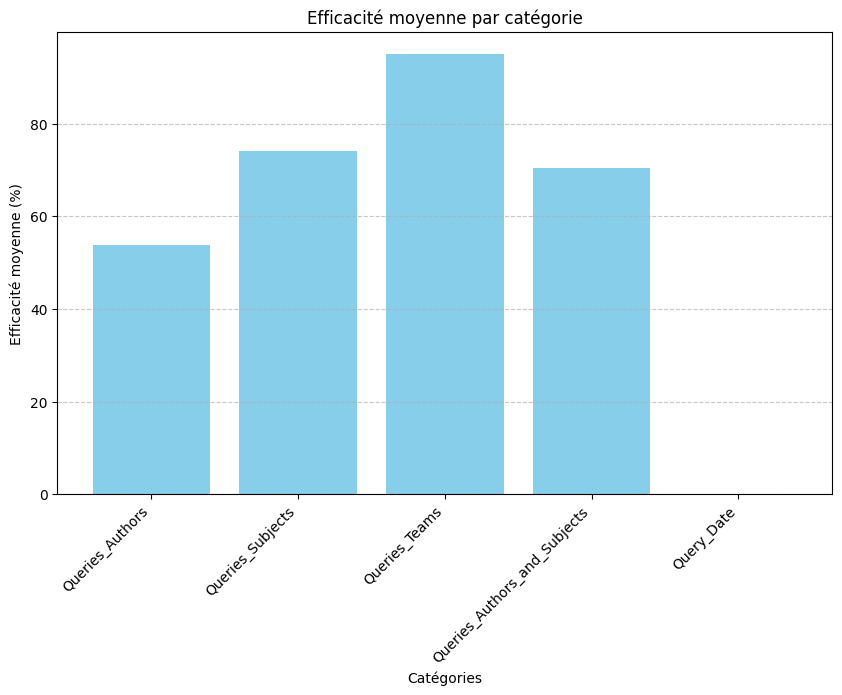

In [7]:
# Données pour le graphique
categories = list(resultats_categories.keys())
scores = [float(c["Efficacite_moyenne"].strip('%')) for c in resultats_categories.values()]

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(categories, scores, color="skyblue")
plt.xlabel("Catégories")
plt.ylabel("Efficacité moyenne (%)")
plt.title("Efficacité moyenne par catégorie")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()